# Proyek Klasifikasi Gambar: [Waste Classification]
- **Nama:** [Haekal Hasan Thanvindra]
- **Email:** [mc295d5y1802@student.devacademy.id]
- **ID Dicoding:** [MC295D5Y1802]

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import shutil
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.1


## Data Preparation

### Data Loading

Train class distribution:
Organic: 12565
Recyclable: 9999

Test class distribution:
Organic: 1401
Recyclable: 1112


C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


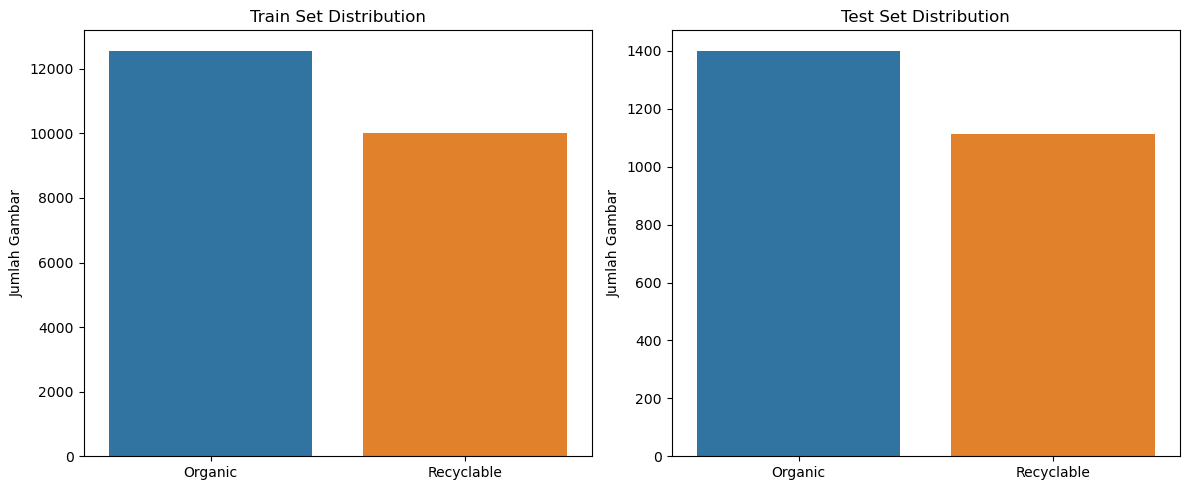

In [2]:
# Path ke dataset
train_dir = "../dataset/train"
test_dir = "../dataset/test"

# Cek jumlah gambar per kelas di train
train_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name)))
                for class_name in os.listdir(train_dir)}

# Cek jumlah gambar per kelas di test
test_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name)))
               for class_name in os.listdir(test_dir)}

print("Train class distribution:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nTest class distribution:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")

# Visualisasi distribusi kelas
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0])
ax[0].set_title('Train Set Distribution')
ax[0].set_ylabel('Jumlah Gambar')

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[1])
ax[1].set_title('Test Set Distribution')
ax[1].set_ylabel('Jumlah Gambar')

plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [3]:
mypath = '../dataset/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        if name.endswith(('.jpg', '.png', '.jpeg')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))
            file_name.append(name)

df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})
print(df['labels'].value_counts())

labels
Organic       13966
Recyclable    11111
Name: count, dtype: int64


In [6]:
X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

df_train = pd.DataFrame({
    'path': X_train,
    'file_name': df.loc[X_train.index, 'file_name'].values,
    'labels': y_train,
    'set': 'train'
})

df_test = pd.DataFrame({
    'path': X_test,
    'file_name': df.loc[X_test.index, 'file_name'].values,
    'labels': y_test,
    'set': 'test'
})

df_all = pd.concat([df_train, df_test], ignore_index=True)
print(df_all.groupby(['set', 'labels']).size())

set    labels    
test   Organic        2794
       Recyclable     2222
train  Organic       11172
       Recyclable     8889
dtype: int64


In [7]:
base_output_path = '../WasteDataset-Final/'

for index, row in tqdm(df_all.iterrows(), total=len(df_all)):
    src = row['path']
    dst_folder = os.path.join(base_output_path, row['set'], row['labels'])
    os.makedirs(dst_folder, exist_ok=True)
    dst = os.path.join(dst_folder, row['file_name'])
    shutil.copy2(src, dst)

100%|███████████████████████████████████████████████████████████████████████████| 25077/25077 [01:25<00:00, 294.70it/s]


In [12]:
# Definisikan direktori training dan test
TRAIN_DIR = '../WasteDataset-Final/train/'
TEST_DIR = '../WasteDataset-Final/test/'

# Cek jumlah gambar untuk masing-masing kelas (Pastikan folder sudah sesuai)
train_organic = os.path.join(TRAIN_DIR, 'Organic')
train_recyclable = os.path.join(TRAIN_DIR, 'Recyclable')
test_organic = os.path.join(TEST_DIR, 'Organic')
test_recyclable = os.path.join(TEST_DIR, 'Recyclable')

print("Total number of organic images in training set: ", len(os.listdir(train_organic)))
print("Total number of recyclable images in training set: ", len(os.listdir(train_recyclable)))
print("Total number of organic images in test set: ", len(os.listdir(test_organic)))
print("Total number of recyclable images in test set: ", len(os.listdir(test_recyclable)))

Total number of organic images in training set:  11172
Total number of recyclable images in training set:  8889
Total number of organic images in test set:  2794
Total number of recyclable images in test set:  2222


In [13]:
# ImageDataGenerator untuk Training dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi pixel
    rotation_range=20,  # Rotasi gambar acak
    zoom_range=0.2,  # Zoom acak
    horizontal_flip=True,  # Flip gambar secara horizontal
    validation_split=0.2  # Split data untuk validasi
)

# ImageDataGenerator untuk Testing (tanpa augmentasi, hanya rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),  # Ukuran gambar setelah diubah
    batch_size=32,  # Ukuran batch
    color_mode="rgb",  # Warna gambar (bukan grayscale)
    class_mode='binary',  # Dua kelas: Organic vs Recyclable
    subset='training',  # Data training
    shuffle=True,  # Mengacak urutan gambar
    seed=42  # Seed untuk reproducibility
)

# Generator untuk data validasi
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),  # Ukuran gambar setelah diubah
    batch_size=32,  # Ukuran batch
    color_mode="rgb",  # Warna gambar (bukan grayscale)
    class_mode='binary',  # Dua kelas: Organic vs Recyclable
    subset='validation',  # Data validasi
    shuffle=False  # Tidak mengacak urutan gambar
)

# Generator untuk data test
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),  # Ukuran gambar setelah diubah
    batch_size=1,  # Ukuran batch
    color_mode="rgb",  # Warna gambar (bukan grayscale)
    class_mode='binary',  # Dua kelas: Organic vs Recyclable
    shuffle=False  # Tidak mengacak urutan gambar
)

# Verifikasi jumlah data
print(f"Training set size: {train_generator.samples}")
print(f"Validation set size: {validation_generator.samples}")
print(f"Test set size: {test_generator.samples}")

Found 16050 images belonging to 2 classes.
Found 4011 images belonging to 2 classes.
Found 5016 images belonging to 2 classes.
Training set size: 16050
Validation set size: 4011
Test set size: 5016


## Modelling

In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
501/501 [==============================] - 381s 758ms/step - loss: 0.4647 - accuracy: 0.7945 - val_loss: 0.3916 - val_accuracy: 0.8250
Epoch 2/10
501/501 [==============================] - 223s 445ms/step - loss: 0.3955 - accuracy: 0.8302 - val_loss: 0.3867 - val_accuracy: 0.8355
Epoch 3/10
501/501 [==============================] - 242s 483ms/step - loss: 0.3627 - accuracy: 0.8462 - val_loss: 0.3409 - val_accuracy: 0.8630
Epoch 4/10
501/501 [==============================] - 224s 446ms/step - loss: 0.3529 - accuracy: 0.8549 - val_loss: 0.3701 - val_accuracy: 0.8443
Epoch 5/10
501/501 [==============================] - 223s 444ms/step - loss: 0.3473 - accuracy: 0.8575 - val_loss: 0.3544 - val_accuracy: 0.8485
Epoch 6/10
501/501 [==============================] - 220s 439ms/step - loss: 0.3329 - accuracy: 0.8631 - val_loss: 0.3307 - val_accuracy: 0.8625
Epoch 7/10
501/501 [==============================] - 222s 443ms/step - loss: 0.3285 - accuracy: 0.8659 - val_loss: 0.3218 -

## Evaluasi dan Visualisasi

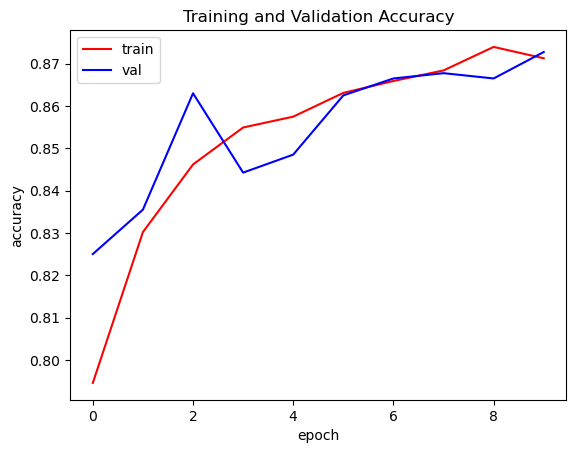

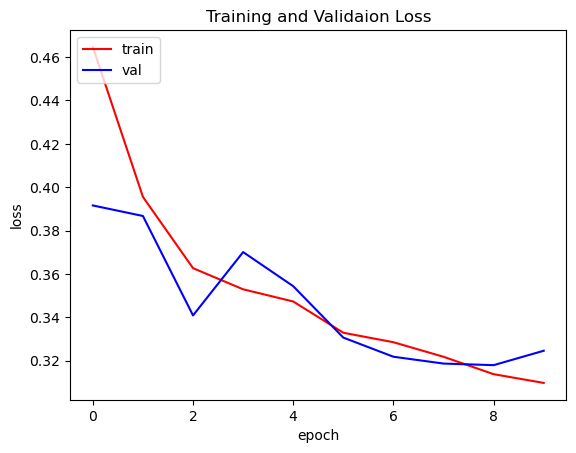

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
 
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

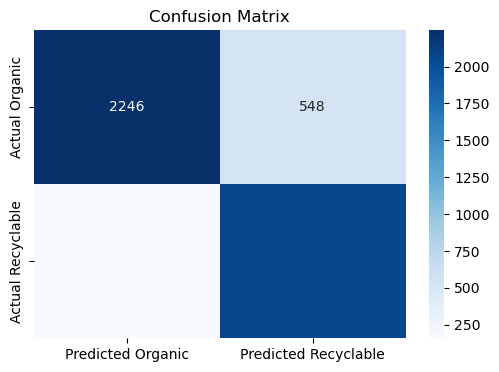


Classification Report:

              precision    recall  f1-score   support

     Organic     0.9343    0.8039    0.8642      2794
  Recyclable     0.7902    0.9289    0.8540      2222

    accuracy                         0.8593      5016
   macro avg     0.8622    0.8664    0.8591      5016
weighted avg     0.8705    0.8593    0.8596      5016



In [20]:
test_generator.reset()

preds = model.predict(test_generator, verbose=0)
preds = preds.copy()
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1

cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds, labels=[0, 1]),
    index=["Actual Organic", "Actual Recyclable"],
    columns=["Predicted Organic", "Predicted Recyclable"]
)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds,
    target_names=['Organic', 'Recyclable'],
    digits=4
))

## Konversi Model

In [24]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [25]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

with open('tflite/label.txt', 'w') as f:
    f.write('Organic\nRecyclable')

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

## Inference (Optional)